In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns

from math import sqrt
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import RANSACRegressor, HuberRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV

## 1. Cargando los datos

In [2]:
dataset = pd.read_csv('..\datos_procesados\datos_procesados.csv')
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)
dataset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,0,65.0,8450,0,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
1,20,0,80.0,9600,0,0,0,0,1,0,...,0,0,0,0,0,5,2007,0,0,181500
2,60,0,68.0,11250,0,0,1,0,0,0,...,0,0,0,0,0,9,2008,0,0,223500
3,70,0,60.0,9550,0,0,1,0,2,0,...,0,0,0,0,0,2,2006,0,1,140000
4,60,0,84.0,14260,0,0,1,0,1,0,...,0,0,0,0,0,12,2008,0,0,250000


## 2. Observando la correlación de todos los features con la variable SalePrice

In [3]:
corr_var = dataset.corr()
corr_var_SalePrice = corr_var.loc['SalePrice',:]
corr_var_SalePrice


MSSubClass      -0.088032
MSZoning        -0.110409
LotFrontage      0.344270
LotArea          0.299962
Street          -0.055601
                   ...   
MoSold           0.051568
YrSold          -0.011869
SaleType         0.089236
SaleCondition    0.188314
SalePrice        1.000000
Name: SalePrice, Length: 79, dtype: float64

#### 2.1 Eliminando los features que no tengan una correlación fuerte con la variable SalePrice (correlación < 0.6)

In [4]:
features_sin_correlacion = corr_var_SalePrice[corr_var_SalePrice<0.6].index.to_list()
dataset = dataset.drop(features_sin_correlacion, axis=1)
dataset

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,GarageCars,GarageArea,SalePrice
0,7,856,856,1710,2,548,208500
1,6,1262,1262,1262,2,460,181500
2,7,920,920,1786,2,608,223500
3,7,756,961,1717,3,642,140000
4,8,1145,1145,2198,3,836,250000
...,...,...,...,...,...,...,...
1116,6,953,953,1647,2,460,175000
1117,6,1542,2073,2073,2,500,210000
1118,7,1152,1188,2340,1,252,266500
1119,5,1078,1078,1078,1,240,142125


Se puede apreciar que las variables que tienen una mayor correlación con la variable SalePrice son: OverallQual, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageCars y GarageArea

#### 2.2 Mostrando de nuevo la matrix de correlación

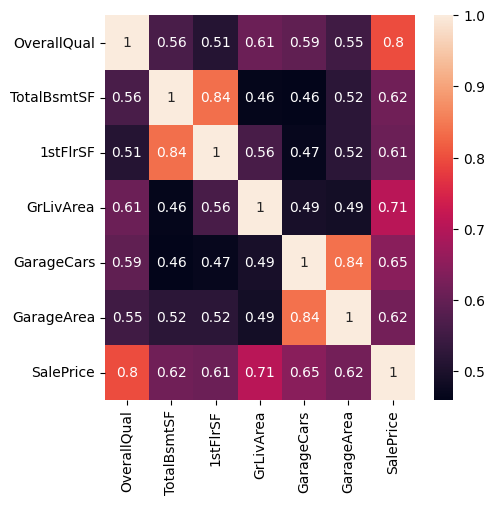

In [5]:
fig = plt.figure(figsize=(5,5))
sns.heatmap(dataset.corr(), annot=True)
plt.show()

## 3. Definiendo los features y la variable a predecir

In [6]:
X = dataset.drop(['SalePrice'], axis=1)
y = dataset[['SalePrice']]

## 4. Se realiza el escalamiento de los datos

In [7]:
esc_rob = RobustScaler()
X_esc = esc_rob.fit_transform(X=X)

## 5. División de los datos en train y test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_esc, y, test_size=0.3, random_state=42)

## 6. Regresión robusta con Huber

In [9]:
#Entrenando el algoritmo
huber = HuberRegressor(epsilon=1.35)
huber.fit(X=X_train, y=y_train)

HuberRegressor()

In [10]:
#Evaluando la predicciones
y_pred_train = huber.predict(X=X_train)
y_pred_test = huber.predict(X=X_test)

r2_sc_train = r2_score(y_true=y_train, y_pred=y_pred_train)
r2_sc_test = r2_score(y_true=y_test, y_pred=y_pred_test)

RMSR_train = sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
RMSR_test = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))

print("R^2 train: {:.2f}".format(r2_sc_train))
print("R^2 test: {:.2f}".format(r2_sc_test))

print("\nRMSR train: {:.0f} USD".format(RMSR_train))
print("RMSR test: {:.0f} USD".format(RMSR_test))

R^2 train: 0.73
R^2 test: 0.77

RMSR train: 41576 USD
RMSR test: 42680 USD


Se puede apreciar que el RMSR de train y de test son muy parecidos, por lo cual no se aprecia overfitting

## 7. Regresión robusta con Ransac

In [11]:
#Entrenando el algoritmo
ransac = RANSACRegressor()
ransac.fit(X=X_train, y=y_train)

RANSACRegressor()

In [12]:
#Evaluando la predicciones
y_pred_train = ransac.predict(X=X_train)
y_pred_test = ransac.predict(X=X_test)

r2_sc_train = r2_score(y_true=y_train, y_pred=y_pred_train)
r2_sc_test = r2_score(y_true=y_test, y_pred=y_pred_test)

RMSR_train = sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
RMSR_test = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))

print("R^2 train: {:.2f}".format(r2_sc_train))
print("R^2 test: {:.2f}".format(r2_sc_test))

print("\nRMSR train: {:.0f} USD".format(RMSR_train))
print("RMSR test: {:.0f} USD".format(RMSR_test))

R^2 train: 0.67
R^2 test: 0.65

RMSR train: 46045 USD
RMSR test: 52987 USD


Se puede apreciar que el RMSR de train y de test son muy parecidos, por lo cual no se aprecia overfitting

## 8. Optimización parámetrica de regresor Huber con búsqueda aleatoria

#### 7.1 Creando el modelo Huber optimizado

In [13]:
huber_ = HuberRegressor()

#Cargando la grilla de parámetros
parametros = {
    'epsilon' : np.linspace(1,3,1000)
}

#Creando el optimizador
huber_opt = RandomizedSearchCV(
    huber_, 
    parametros, 
    n_iter=20, 
    cv=5,
    scoring='neg_root_mean_squared_error'
)

#Entrenando el modelo optimizado
huber_opt.fit(X_train,y_train)

#Imprimiendo el regresor encontrado
print(huber_opt.best_estimator_)

HuberRegressor(epsilon=1.7407407407407407)


#### 8.1 Evaluando el modelo

In [14]:
#Evaluando la predicciones
y_pred_train = huber_opt.predict(X=X_train)
y_pred_test = huber_opt.predict(X=X_test)

r2_sc_train = r2_score(y_true=y_train, y_pred=y_pred_train)
r2_sc_test = r2_score(y_true=y_test, y_pred=y_pred_test)

RMSR_train = sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
RMSR_test = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))

print("R^2 train: {:.2f}".format(r2_sc_train))
print("R^2 test: {:.2f}".format(r2_sc_test))

print("\nRMSR train: {:.0f} USD".format(RMSR_train))
print("RMSR test: {:.0f} USD".format(RMSR_test))

R^2 train: 0.73
R^2 test: 0.78

RMSR train: 41469 USD
RMSR test: 41923 USD


## 9. Graficando los resultados

In [15]:
#Graficando los resultados
df_comp = y_test.copy()
df_comp['SalePrice HUBER'] = np.round(huber.predict(X=X_test), decimals=0)
df_comp['SalePrice HUBER opt'] = np.round(huber_opt.predict(X=X_test), decimals=0)
df_comp['SalePrice RANSAC'] = np.round(ransac.predict(X=X_test), decimals=0)
df_comp.head()

,SalePrice,SalePrice HUBER,SalePrice HUBER opt,SalePrice RANSAC
996,140000,144981.0,145062.0,145200.0
101,150750,157121.0,156460.0,150261.0
231,157000,141780.0,140937.0,133686.0
1004,138000,131658.0,130659.0,137479.0
605,144000,159647.0,160400.0,135181.0


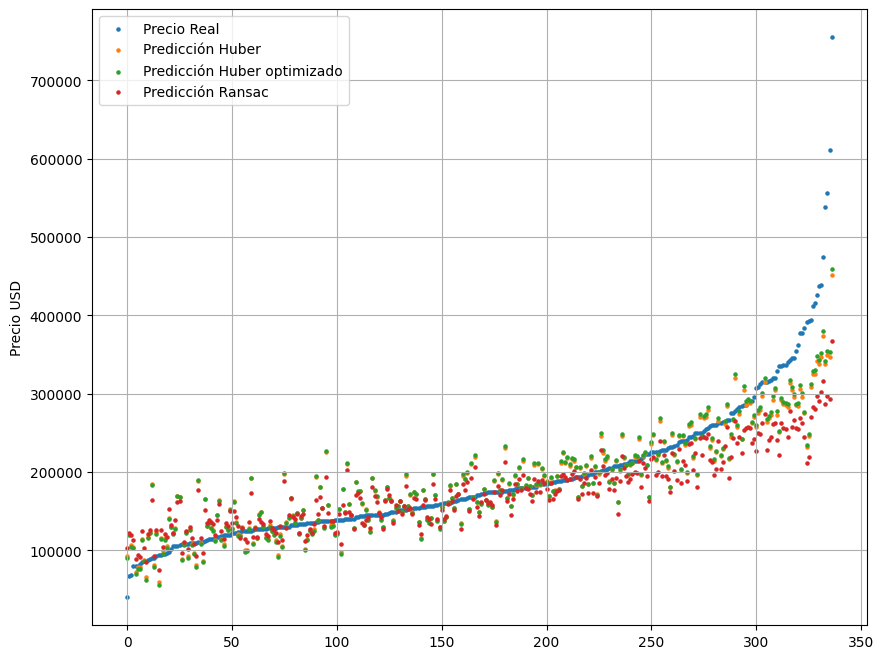

In [16]:
df_comp.sort_values('SalePrice', inplace=True)
x = range(len(df_comp['SalePrice'].to_list()))
size_dot = 5
plt.figure(figsize=(10,8))
plt.scatter(x, df_comp['SalePrice'], label='Precio Real', s=size_dot)
plt.scatter(x, df_comp['SalePrice HUBER'], label='Predicción Huber', s=size_dot)
plt.scatter(x, df_comp['SalePrice HUBER opt'], label='Predicción Huber optimizado', s=size_dot)
plt.scatter(x, df_comp['SalePrice RANSAC'], label='Predicción Ransac', s=size_dot)
plt.ylabel('Precio USD')
plt.legend()
plt.grid()
plt.show()

## 10. Regresión polinómica

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [18]:
#Se define el grado del polinomio
poli_reg = PolynomialFeatures(degree = 2)

#Se transforma las características existentes en características de mayor grado
X_train_poli = poli_reg.fit_transform(X_train)
X_test_poli = poli_reg.fit_transform(X_test)

#Definimos el algoritmo a utilizar
pr = LinearRegression()

#Entrenamos el modelo
pr.fit(X_train_poli, y_train)

LinearRegression()

In [19]:
#Evaluando la predicciones
y_pred_train = pr.predict(X=X_train_poli)
y_pred_test = pr.predict(X=X_test_poli)

r2_sc_train = r2_score(y_true=y_train, y_pred=y_pred_train)
r2_sc_test = r2_score(y_true=y_test, y_pred=y_pred_test)

RMSR_train = sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred_train))
RMSR_test = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_test))

print("R^2 train: {:.2f}".format(r2_sc_train))
print("R^2 test: {:.2f}".format(r2_sc_test))

print("\nRMSR train: {:.0f} USD".format(RMSR_train))
print("RMSR test: {:.0f} USD".format(RMSR_test))

R^2 train: 0.84
R^2 test: 0.85

RMSR train: 31584 USD
RMSR test: 34336 USD


In [20]:
y_real = y_test.copy()
y_real['y pred'] = np.round(pr.predict(X=X_test_poli), decimals=0)
y_real

,SalePrice,y pred
996,140000,129117.0
101,150750,148608.0
231,157000,143413.0
1004,138000,128678.0
605,144000,83697.0
...,...,...
787,87000,121023.0
939,112000,135276.0
428,255500,294643.0
693,122900,110829.0


In [21]:
y_real.sort_values('SalePrice', inplace=True)
y_real

,SalePrice,y pred
25,40000,109491.0
306,67000,129849.0
982,68400,109635.0
458,79500,108414.0
55,80000,99153.0
...,...,...
137,475000,537879.0
597,538000,385517.0
802,556581,407126.0
700,611657,404743.0


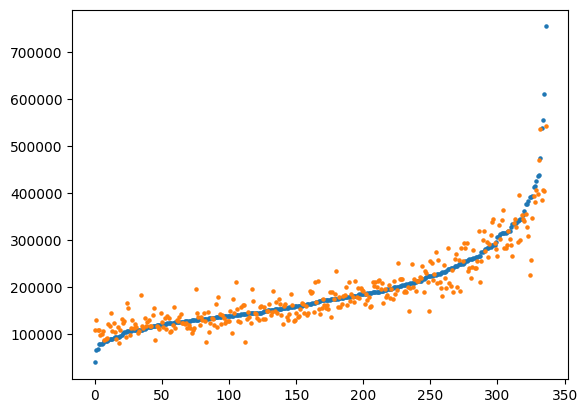

In [22]:
x = range(0,len(y_real['SalePrice'].to_list()))
plt.scatter(x, y_real['SalePrice'], s=5)
plt.scatter(x, y_real['y pred'], s=5)